In [1]:
import os
from glob     import glob
from datetime import datetime

import numpy  as np
import pandas as pd

import matplotlib.pyplot as plt

from CCdb   import _default_reference_file as references

from CCio   import load_hdf

from CCcore import rebin_df
from CCcore import histogram
from CCcore import integrate_peak

from CCfit  import fit
from CCfit  import gauss

from CCplot import auto_plot_style
from CCplot import figure
from CCplot import subplot
from CCplot import plot1d
from CCplot import plot2d

In [2]:
%matplotlib inline
%load_ext autoreload

%autoreload 2
auto_plot_style()

In [3]:
Sph = load_hdf(references, None, "Sp" )
ZnO = load_hdf(references, None, "ZnO")
Qz  = load_hdf(references, None, "Qz" )
bkg = load_hdf(references, None, "Background")
amb = load_hdf(references, None, "Ambient")
bsl = load_hdf(references, None, "Baseline")

# Sp

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


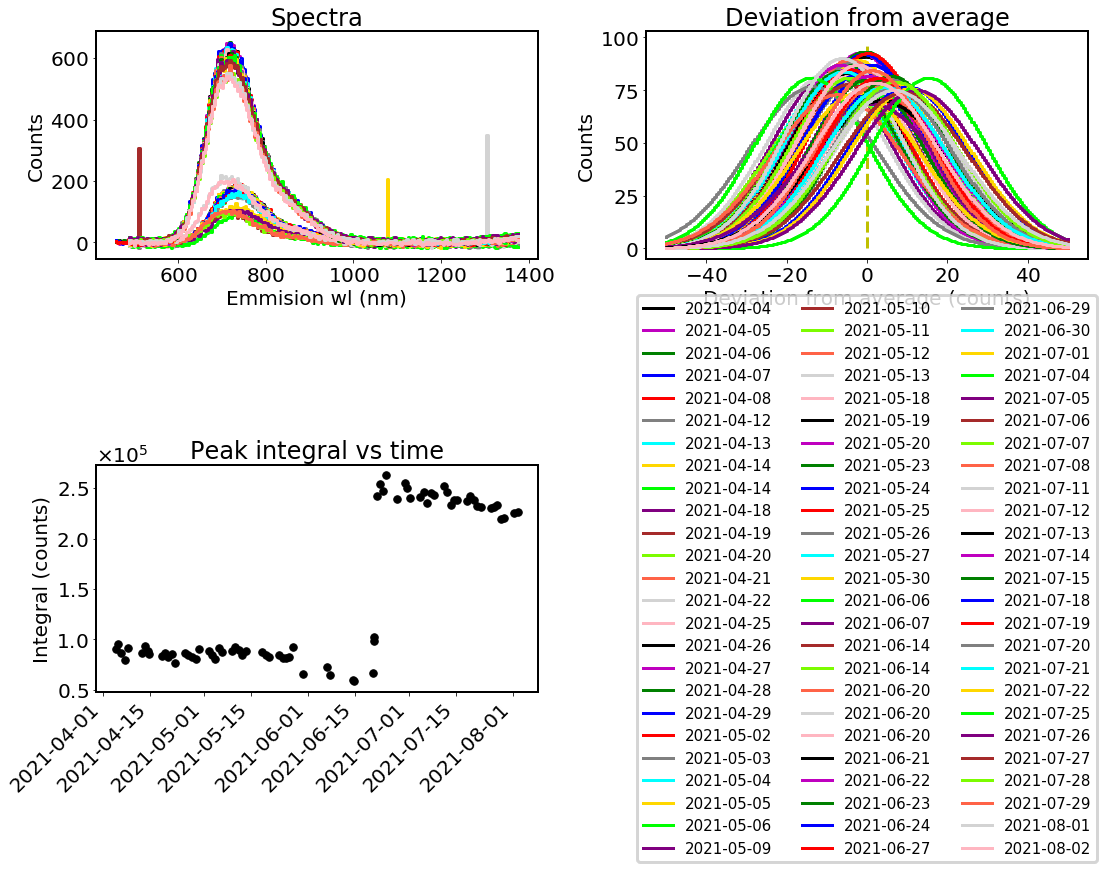

In [4]:
rebin  = 8
column = "bls"
drange = np.linspace(-50, 50, 201) 
dbins  = drange[::4]

fig = figure(4)
subplot(4, 1)
for t, data in Sph.groupby("datetime"):
    data = rebin_df(data, rebin)
    plot1d(data.em_wl, getattr(data, column), label=str(t.date()))

plt.title("Spectra")
handles, labels = plt.gca().get_legend_handles_labels()

subplot(4, 2)
average = Sph.groupby(Sph.index % 2048, as_index=False).mean().reset_index()

for t, data in Sph.groupby("datetime"):
    diff = getattr(data, column).values - getattr(average, column).values
    y, x = histogram(diff, dbins)
    f = fit(gauss, x, y, (0, 1, 1))
    plot1d(drange, f.fn(drange), label=str(t.date()))

plt.title("Deviation from average")
plt.vlines(0, 0, plt.ylim()[1], colors="y", linestyle="--")
plt.xlabel("Deviation from average (counts)")

subplot(4, 3)
integrals = [(t, integrate_peak(data, 600, 1000, column))
             for t, data in Sph.groupby("datetime")]

dates, integrals = map(np.asarray, zip(*integrals))
plt.errorbar(dates, integrals, integrals**0.5, fmt=".k")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Integral (counts)")
plt.title("Peak integral vs time")

subplot(4, 4)
plt.legend(handles, labels, loc="center", fontsize=15, ncol=3)
plt.axis("off")
plt.tight_layout()

(1e-06, 0.0001)

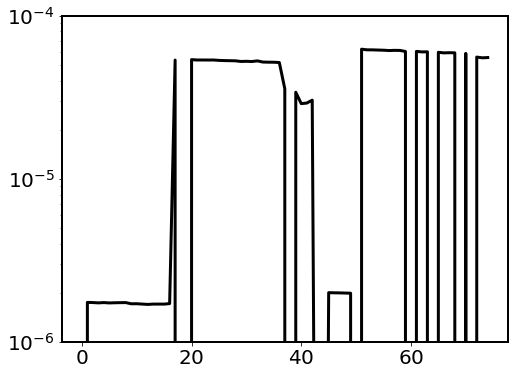

In [5]:
plt.plot([df.power0.max() for i, df in Sph.groupby("timestamp")])
plt.yscale("log")
plt.ylim(1e-6, 1e-4)

# ZnO

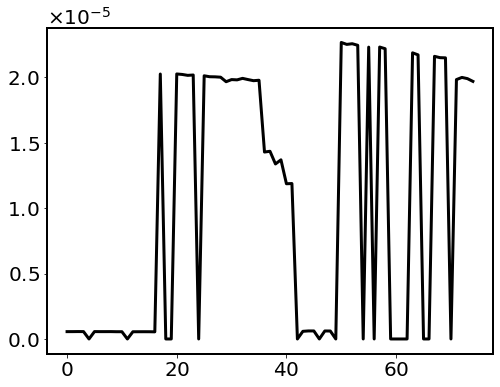

In [6]:
plt.plot([df.power0.mean() for _, df in ZnO.groupby("datetime")])

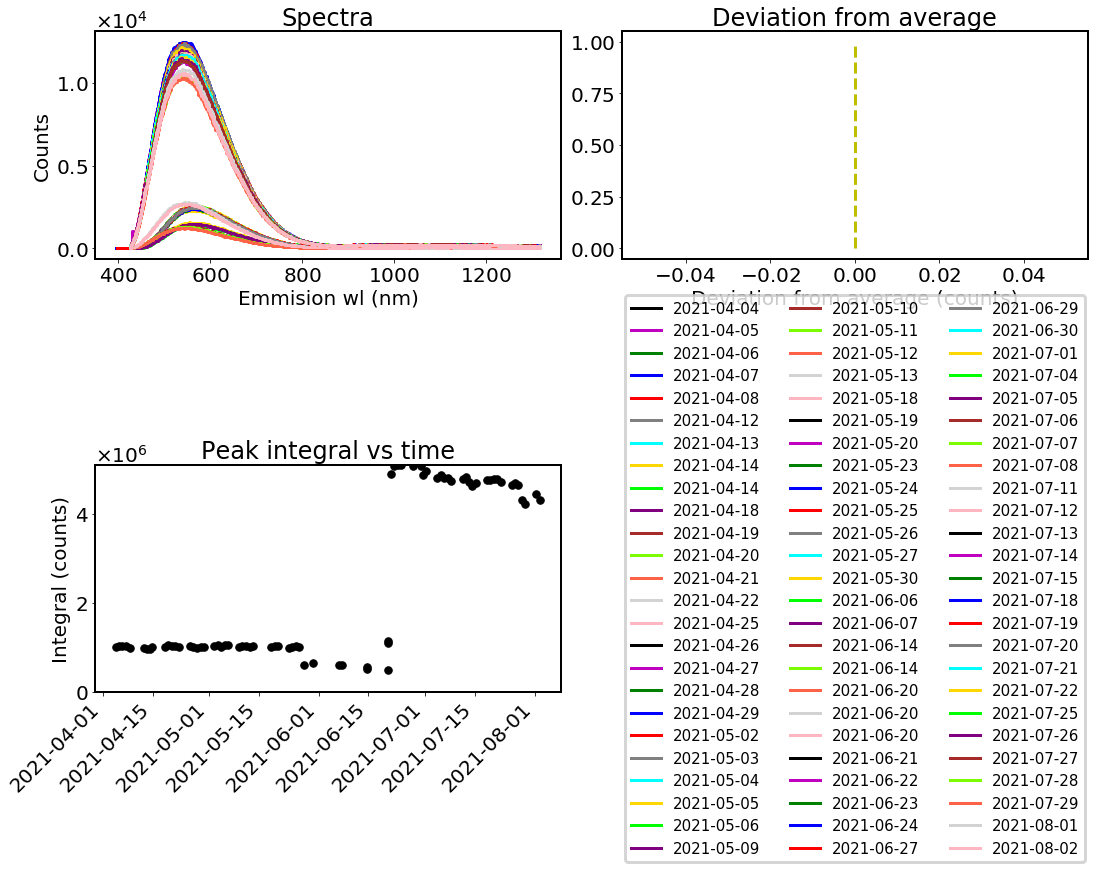

In [7]:
rebin  = 5
column = "bls"
drange = np.linspace(-50, 50, 201) 
dbins  = drange[::4]

fig = figure(4)
subplot(4, 1)
for t, data in ZnO.groupby("datetime"):
    data = rebin_df(data, rebin)
    plot1d(data.em_wl, getattr(data, column), label=str(t.date()))

plt.title("Spectra")
handles, labels = plt.gca().get_legend_handles_labels()

subplot(4, 2)
average = ZnO.groupby(ZnO.index % 2048).mean().reset_index()

for t, data in ZnO.groupby("datetime"):
    diff = getattr(data, column).values - getattr(average, column).values
    y, x = histogram(diff, dbins)
#    f = fit(gauss, x, y, (0, 1, 1), maxfev=5000)
#    plot1d(drange, f.fn(drange), label=str(t.date()))

plt.title("Deviation from average")
plt.vlines(0, 0, plt.ylim()[1], colors="y", linestyle="--")
plt.xlabel("Deviation from average (counts)")

subplot(4, 3)
integrals = [(t, integrate_peak(data, 400, 800, column))
             for t, data in ZnO.groupby("datetime")]

dates, integrals = map(np.asarray, zip(*integrals))
plt.errorbar(dates, integrals, integrals**0.5, fmt=".k")
plt.ylim(0, integrals.max())
plt.xticks(rotation=45, ha="right")
plt.ylabel("Integral (counts)")
plt.title("Peak integral vs time")

subplot(4, 4)
plt.legend(handles, labels, loc="center", fontsize=15, ncol=3)
plt.axis("off")
plt.tight_layout()

In [8]:
from scipy.interpolate import interp1d
ts  = [d.timestamp() for d in dates]
ins = interp1d(ts, integrals)
ts  = np.linspace(dates.min().timestamp(), dates.max().timestamp(), 201)
ins = ins(ts)
ts  = np.array(list(map(datetime.fromtimestamp, ts)))


Text(0, 0.5, 'ZnO peak integral (counts)')

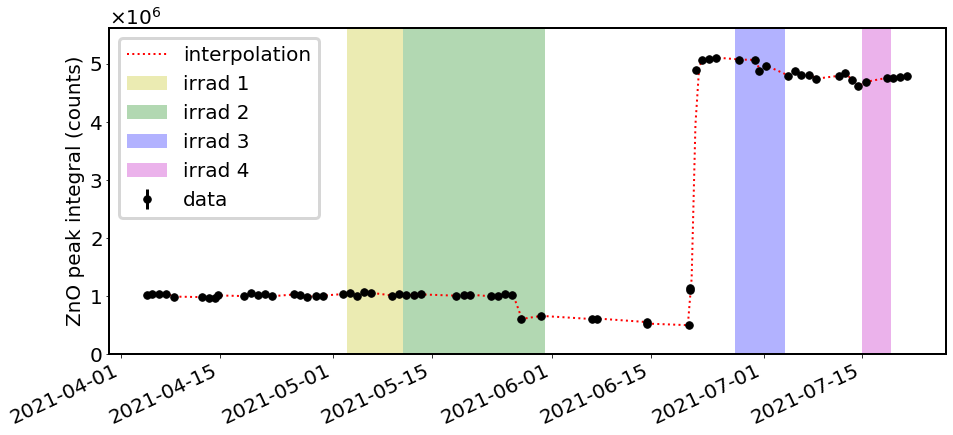

In [42]:
plt.figure(figsize=(15, 6))
plt.errorbar(dates, integrals, integrals**0.5, fmt=".k", label="data")
plt.plot    (   ts, ins, "r:", label="interpolation", lw=2)
plt.ylim(0, integrals.max() * 1.1)
plt.fill_betweenx(plt.ylim(), datetime(2021, 5,  3), datetime(2021, 5, 11), facecolor="y", alpha=0.3, label="irrad 1")
plt.fill_betweenx(plt.ylim(), datetime(2021, 5, 11), datetime(2021, 5, 31), facecolor="g", alpha=0.3, label="irrad 2")
plt.fill_betweenx(plt.ylim(), datetime(2021, 6, 27), datetime(2021, 7,  4), facecolor="b", alpha=0.3, label="irrad 3")
plt.fill_betweenx(plt.ylim(), datetime(2021, 7, 15), datetime(2021, 7, 19), facecolor="m", alpha=0.3, label="irrad 4")

plt.legend()
plt.xticks(rotation=25, ha="right")
plt.ylabel("ZnO peak integral (counts)")

In [9]:
df = pd.DataFrame(dict(timestamp = [d.timestamp() for d in dates],
                       integral  = integrals))
df.to_hdf("/home/gonzalo/data/CC/pre-annealing-experiment/power_normalization.h5", "/integrals")

In [37]:
df

timestamp   integral
0   1.617557e+09  1013534.5
1   1.617614e+09  1035970.7
2   1.617700e+09  1036875.0
3   1.617786e+09  1037422.7
4   1.617880e+09   991850.8
..           ...        ...
62  1.626350e+09  4694278.5
63  1.626602e+09  4760048.4
64  1.626683e+09  4753833.2
65  1.626773e+09  4777520.5
66  1.626857e+09  4789201.8

[67 rows x 2 columns]

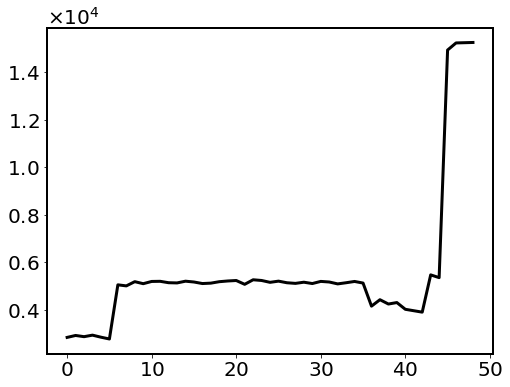

In [8]:
plt.plot([df.counts.max() for i, df in ZnO.groupby("timestamp")])

In [ ]:

plt.plot()

# Qz

In [45]:
column = getattr(data, column)

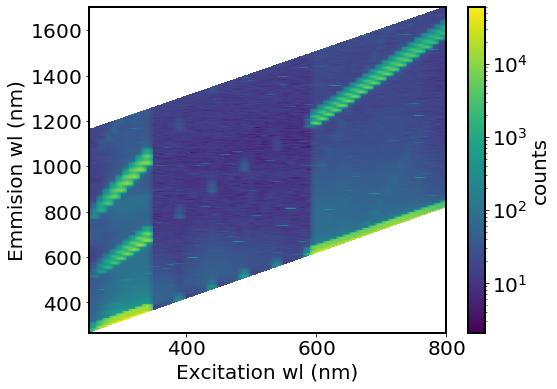

In [42]:
data = Qz.groupby(Qz.index % (2048 * 56), as_index=False).mean()
plot2d(data.ex_wl, data.em_wl, data.counts - data.counts.min() + 1, log=True);

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  if __name__ == '__main__':


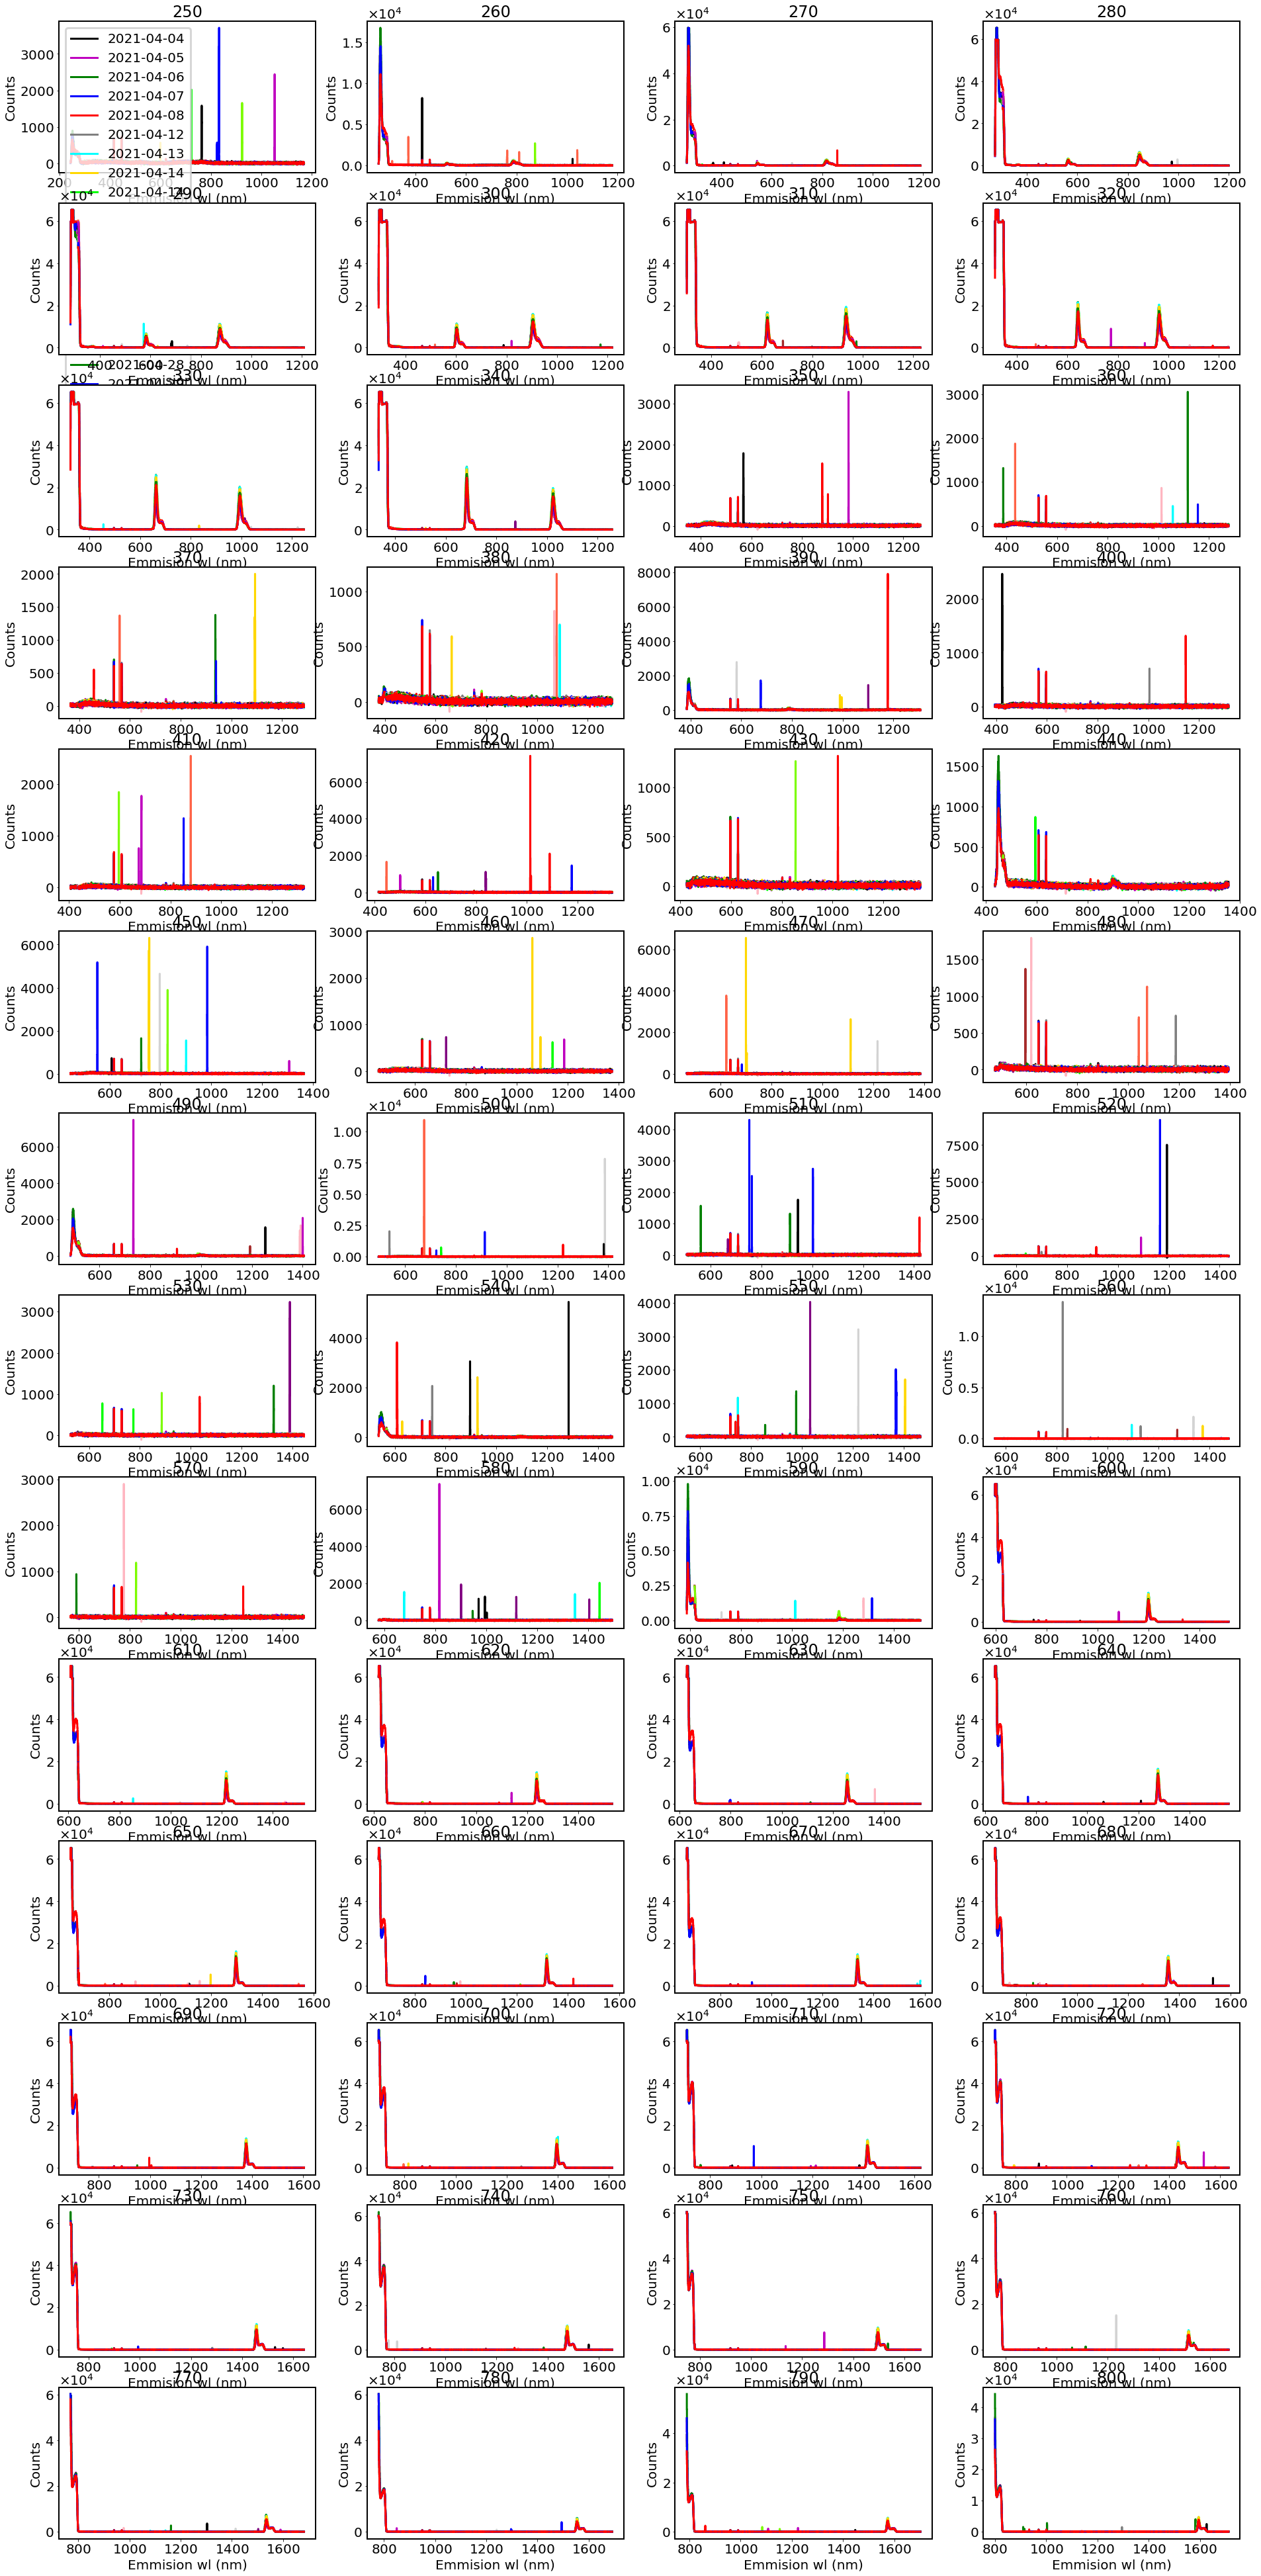

In [44]:
plt.figure(figsize=(8*4, 5*14))
for ex_wl, datas in Qz.groupby("ex_wl"):
    plt.subplot(14, 4, (ex_wl - 240) // 10)
    for t, data in datas.groupby("datetime"):
        plot1d(data.em_wl, getattr(data, column), title=str(ex_wl), label=str(t.date()))
    if ex_wl == 250:
        plt.legend()

plt.tight_layout()

# Background

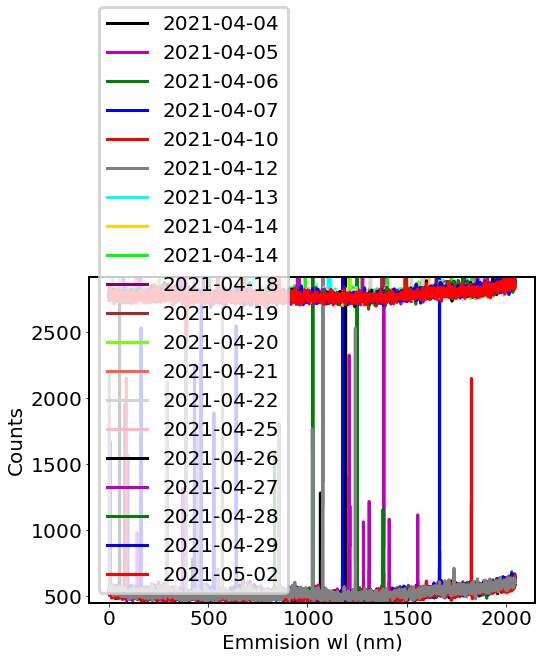

In [48]:
ymin = np.inf
ymax = 0
column = "counts"
for t, data in bkg.groupby("datetime"):
    plot1d(np.arange(len(data)), getattr(data, column), label=str(t.date()))
    ymin = min(ymin, np.percentile(data.counts,  0.5))
    ymax = max(ymax, np.percentile(data.counts, 98.6))
    
plt.ylim(ymin, ymax)
plt.legend()

# Ambient

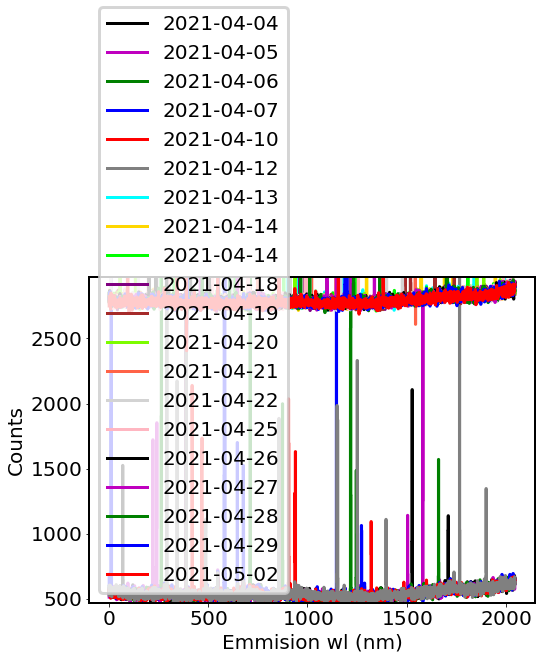

In [49]:
ymin = np.inf
ymax = 0
for t, data in amb.groupby("datetime"):
    plot1d(np.arange(len(data)), data.counts, label=str(t.date()))
    ymin = min(ymin, np.percentile(data.counts,  0.5))
    ymax = max(ymax, np.percentile(data.counts, 98.6))
    
plt.ylim(ymin, ymax)
plt.legend()

# Baseline

/home/gonzalo/sw/anaconda3/envs/CC/lib/python3.7/site-packages/scipy/optimize/minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


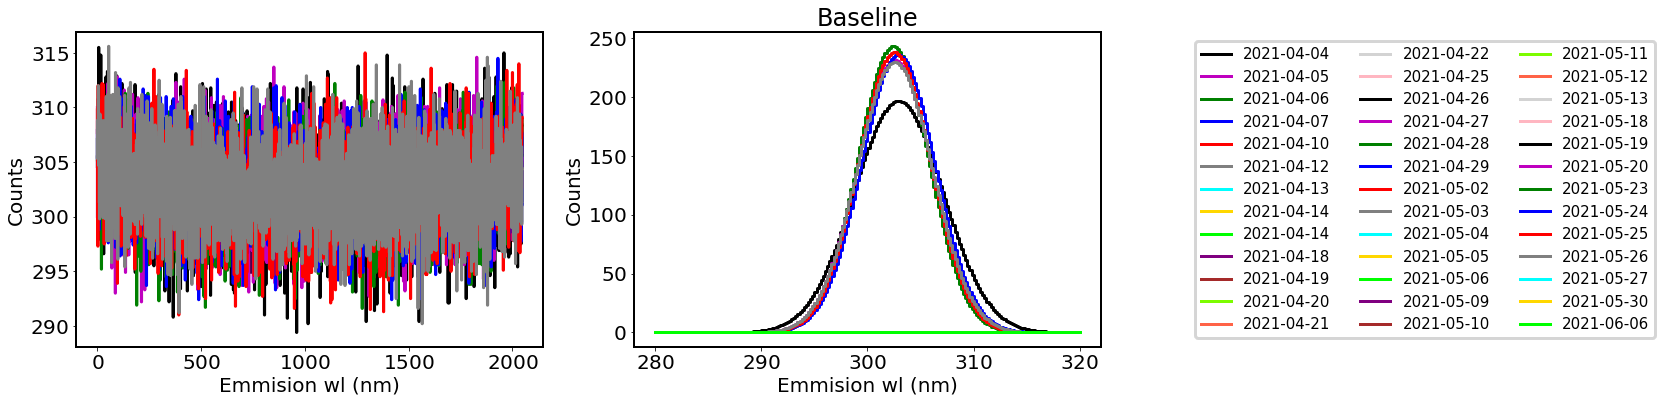

In [7]:
brange = np.linspace(280, 320, 201)
bbins  = brange[::5]

figure(3)
subplot(3, 1)
for t, data in bsl.groupby("datetime"):
    data = data.loc[data.counts < 350]
    plot1d(np.arange(len(data)), data.counts, label=str(t.date()))
handles, labels = plt.gca().get_legend_handles_labels()
    
subplot(3, 2)
for t, data in bsl.groupby("datetime"):
    y, x = histogram(data.counts, bbins)
    f    = fit(gauss, x, y, (0, np.mean(brange), 1))
    plot1d(brange, f.fn(brange), label=str(t.date()))
#    plot1d(x, y, label=str(t.date()))

plt.title("Baseline")

subplot(3, 3)
plt.legend(handles, labels, loc="center", fontsize=15, ncol=3)
plt.axis("off")

plt.tight_layout()